# Check the mining area tiles

In [1]:
import geopandas as gpd
import leafmap
from shapely.ops import unary_union
from shapely.geometry import Point, mapping, box, shape
import shapely
import json
from tqdm import tqdm
tqdm.pandas()
import os

os.chdir("..")
root = os.path.dirname(os.getcwd())
print(root)

import sys
sys.path.append("..")
from src.utils import calculate_dimensions_km

/Users/simonjasansky/programming/mine-segmentation


In [10]:
tiles_path = root + "/data/interim/tiles.gpkg"

# list the layers of the gpkg file
print(gpd.list_layers(tiles_path))
# Load the data
data = gpd.read_file(tiles_path, layer="mining_areas_square")

data.head()

                  name geometry_type
0  mining_areas_square       Polygon
1    mining_areas_rect       Polygon


,centroid,mining_area,geometry
0,POINT (-165.416666 64.583272),3.019279,"POLYGON ((-165.20216 64.49183, -165.20353 64.6..."
1,POINT (-148.916665 63.916609),2.010186,"POLYGON ((-148.70246 63.82736, -148.71364 64.0..."
2,POINT (-139.416668 64.083275),3.935997,"POLYGON ((-139.21268 63.98899, -139.20086 64.1..."
3,POINT (-139.416668 63.916609),2.017951,"POLYGON ((-139.21387 63.82233, -139.20215 64.0..."
4,POINT (-139.416668 63.749943),2.968389,"POLYGON ((-139.21506 63.65566, -139.20343 63.8..."


In [ ]:
calculate_dimensions_km(data.geometry[0])

# iterate over df and calculate the dimensions
data["dimensions"] = data.geometry.progress_apply(calculate_dimensions_km)

In [ ]:
# add index as a column
data["index"] = data.index
data.head()

100%|██████████| 2993/2993 [02:11<00:00, 22.83it/s]


<Axes: >

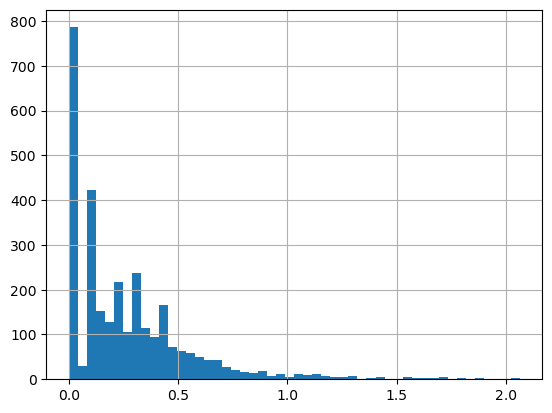

In [13]:
# calculate overlap percentage of each tile
data["overlap_percentage"] = data["geometry"].progress_apply(lambda x: data["geometry"].apply(lambda y: x.intersection(y).area/x.area).sum() - 1)
data["overlap_percentage"].hist(bins=50)

In [4]:
# Create a Map
m = leafmap.Map(zoom=2)

# Add the GeoDataFrame to the map
m.add_gdf(data, layer_name="tiles")

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Calculate number of groups of connected tiles

In [5]:
import geopandas as gpd
import networkx as nx
from tqdm import tqdm

# Step 1: Create a graph
G = nx.Graph()

# Step 2: Add nodes
for idx, geom in tqdm(data.iterrows(), total=len(data), desc="Adding nodes"):
    G.add_node(idx, geometry=geom.geometry)

# Step 3: Add edges for overlapping or touching geometries
for i, geom1 in tqdm(data.iterrows(), total=len(data), desc="Adding edges"):
    for j, geom2 in data.iterrows():
        if i != j and (geom1.geometry.overlaps(geom2.geometry) or geom1.geometry.touches(geom2.geometry)):
            G.add_edge(i, j)

# Step 4: Find connected components
connected_components = list(nx.connected_components(G))

# Step 5: Assign group IDs
group_id = 0
data['overlap_group'] = -1
for component in tqdm(connected_components, desc="Assigning group IDs"):
    for idx in component:
        data.at[idx, 'overlap_group'] = group_id
    group_id += 1

data.head()

,centroid,mining_area,geometry,overlap_group
0,POINT (-165.416666 64.583272),3.019279,"POLYGON ((-165.20216 64.49183, -165.20353 64.6...",0
1,POINT (-148.916665 63.916609),2.010186,"POLYGON ((-148.70246 63.82736, -148.71364 64.0...",1
2,POINT (-139.416668 64.083275),3.935997,"POLYGON ((-139.21268 63.98899, -139.20086 64.1...",2
3,POINT (-139.416668 63.916609),2.017951,"POLYGON ((-139.21387 63.82233, -139.20215 64.0...",2
4,POINT (-139.416668 63.749943),2.968389,"POLYGON ((-139.21506 63.65566, -139.20343 63.8...",2


In [6]:
# check the number of groups
data.overlap_group.nunique()

1174

In [9]:
# check the number of tiles in each group by plotting a hist
data.overlap_group.value_counts()

overlap_group
296     87
284     73
1124    43
308     41
1130    37
        ..
515      1
516      1
519      1
521      1
1173     1
Name: count, Length: 1174, dtype: int64